## Interacting point processes
Noam Siegel, Ben Gurion University

In [32]:
import datetime
from typing import List

import gpytorch
import torch
from gpytorch.variational import UnwhitenedVariationalStrategy, CholeskyVariationalDistribution
from matplotlib import pyplot as plt
from pytorch_lightning import seed_everything

from msc.canine_db_utils import get_onsets, get_record_start
from msc.plot_utils import plot_seizure_occurrences_timeline, plot_seizure_intervals_histogram

seed_everything(42)
%load_ext autoreload
%autoreload 2

Global seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
train_x is in minutes
train_y is the onsets

In [33]:
dog_num = 3
onset_datetimes: List[datetime.datetime] = get_onsets(dog_num)

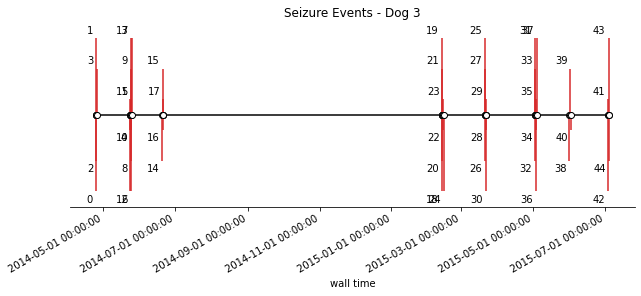

In [34]:
plot_seizure_occurrences_timeline(onset_datetimes, f"Dog 3")

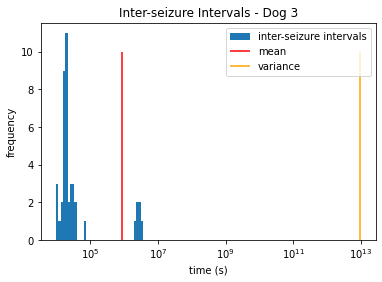

In [35]:
plot_seizure_intervals_histogram(onset_datetimes, "Dog 3")

In [36]:
record_start = get_record_start(dog_num)

In [37]:
timestep = 7200 * 2

In [38]:
onsets_minutes = torch.Tensor([(onset - record_start).total_seconds() / timestep for onset in onset_datetimes])
train_x = torch.arange(0, max(onsets_minutes))
train_y = torch.zeros_like(train_x).index_fill_(0, onsets_minutes.long(), 1)

In [39]:
train_x.size()

torch.Size([2700])

In [40]:
class HawkesProcessGP(gpytorch.models.ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=True
        )
        super(HawkesProcessGP, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel() * gpytorch.kernels.CosineKernel()+ gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(3/2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

In [41]:
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [42]:
model = HawkesProcessGP(train_x)

## Visualize the prior

In [43]:
prior_distribution = likelihood(model(train_x))

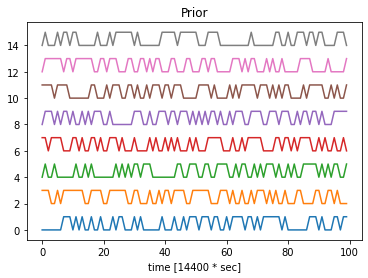

In [44]:
# plot prior samples
n_draws = 8
for i in range(n_draws):
    plt.plot(train_x[:100], (prior_distribution.sample() + 2*i)[:100])
plt.xlabel(f'time [{timestep} * sec]')
plt.title('Prior')
plt.show()

In [45]:
torch.cuda.empty_cache()

In [46]:
smoke_test = False
training_iterations = 2 if smoke_test else 50

# find optimal model hyperparameters
model.train()
likelihood.train()

# move to GPU
assert torch.cuda.is_available()
train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

# use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - marginal log likelihood
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()


Iter 1/50 - Loss: 1.205
Iter 2/50 - Loss: 1.190
Iter 3/50 - Loss: 1.175
Iter 4/50 - Loss: 1.158
Iter 5/50 - Loss: 1.145
Iter 6/50 - Loss: 1.128
Iter 7/50 - Loss: 1.113
Iter 8/50 - Loss: 1.099
Iter 9/50 - Loss: 1.084
Iter 10/50 - Loss: 1.070
Iter 11/50 - Loss: 1.056
Iter 12/50 - Loss: 1.043
Iter 13/50 - Loss: 1.030
Iter 14/50 - Loss: 1.017
Iter 15/50 - Loss: 1.005
Iter 16/50 - Loss: 0.992
Iter 17/50 - Loss: 0.979
Iter 18/50 - Loss: 0.968
Iter 19/50 - Loss: 0.957
Iter 20/50 - Loss: 0.945
Iter 21/50 - Loss: 0.933
Iter 22/50 - Loss: 0.922
Iter 23/50 - Loss: 0.913
Iter 24/50 - Loss: 0.901
Iter 25/50 - Loss: 0.892
Iter 26/50 - Loss: 0.881
Iter 27/50 - Loss: 0.871
Iter 28/50 - Loss: 0.863
Iter 29/50 - Loss: 0.854
Iter 30/50 - Loss: 0.845
Iter 31/50 - Loss: 0.836
Iter 32/50 - Loss: 0.828
Iter 33/50 - Loss: 0.819
Iter 34/50 - Loss: 0.811
Iter 35/50 - Loss: 0.802
Iter 36/50 - Loss: 0.794
Iter 37/50 - Loss: 0.787
Iter 38/50 - Loss: 0.779
Iter 39/50 - Loss: 0.772
Iter 40/50 - Loss: 0.765
Iter 41/5

## Visualize the posterior

In [47]:
likelihood = likelihood.cpu()
model = model.cpu()
train_x = train_x.cpu()
train_y = train_y.cpu()

In [48]:
posterior_distribution = likelihood(model(train_x))


KeyboardInterrupt



In [ ]:
# plot posterior samples
n_draws = 8
for i in range(n_draws):
    plt.plot(train_x[:100], (posterior_distribution.sample() + 2*i)[:100])
plt.xlabel(f'time [{timestep} * sec]')
plt.title('Posterior')
plt.show()